In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pykalman import KalmanFilter
from tqdm import tqdm 

commodities = ['Maize', 'Wheat', 'Oats', 'Soybeans']
DATA_PATH = '/kaggle/input/processed-data'
Y_COLUMN = 'Sep'

In this notebook, we will apply another statistical model for time series, known as Holt-Winters. In this model, the value of the time series is represented as the sum of the trend and the seasonality component, when each are time series themselves. As we observed in the SARIMA models notebook, it is plausible that the commodities dataset exhibits a yearly seasonality effect (as seen in the seasonal decomposition graphs, for instance). We will implement the Holt-Winters model with additive seasonality by representing it as a Kalman Filter (state-space model). Specifically, we will fit it into the Kalman Filter format by selecting particular parameters of the state-space model to coincide with the Holt-Winters equations.

We will apply this model to each of the 4 commodities separately, as we did when utilizing the SARIMA models. If we attempt to apply yearly seasonality, the code crashes because the model size increases significantly (the dimensionality doubles due to squared matrices, where the dimension is the number of variables). Therefore, we will apply monthly seasonality (30 days) instead, with the expectation that it will still capture the yearly seasonality effect and learn to account for it.


Holt winters equations for 30-days seasonality:

$ Y_t = L_t + S_t + ϵ $,    $\hspace{5pt}Y_t$ representing the original series.

$ L_t = L_{t-1} + R_{t-1} + η_1$, $\hspace{5pt}L_t$ representing the trend (level) series.

$ R_t = R_{t-1} + η_2$, $\hspace{5pt}R_t$ representing the change in the trend series.

$ S_t = S_{t-30} + η_3$, $\hspace{5pt}S_t$ representing the seasonality series.

$ S_{t-1} + S_{t-2} + \ldots S_{t-30} = 0$

We use the **Kalman Filters** equations by the following way:

$β_t =  \begin{pmatrix}
L_t \\
R_t \\
S_t \\
S_{t-1} \\
S_{t-2} \\
\vdots \\
S_{t-28}
\end{pmatrix}
$


**Observation matrix, transition matrix:**
\begin{array}{cc}
X = \begin{pmatrix}
1 & 0 & 1 & 0 & 0 & \ldots & 0 \\
\end{pmatrix} ∈ \mathbb{R}^{31},
&
T = \begin{pmatrix}
1 & 1 & 0 & 0 & 0 & \ldots & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & -1 & -1 & -1 & \ldots & -1 & -1 \\
0 & 0 & 1 & 0 & 0 & \ldots & 0 & 0\\
0 & 0 & 0 & 1 & 0 & \ldots & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \vdots & \ldots & \vdots & \vdots \\
0 & 0 & 0 & 0 & 0 & \ldots & 1 & 0\\
\end{pmatrix} \in \mathbb{R}^{31X31}
\end{array}

Now fitting to the Kalman Filters equations, the update equations are:

$ Y_t = Xβ_t + ϵ \hspace{5pt}$,  (Observation equation)

$ β_t = Tβ_{t-1} + η  \hspace{5pt}$,  (Transition equation)

When:  $\eta =  \begin{pmatrix}
\eta_1 \\
\eta_2 \\
\eta_3 \\
0 \\
\vdots \\
0
\end{pmatrix} \in \mathbb{R}^{31}
$

And the variances are:

$ Q \stackrel{\mathrm{def}}{=} Var(\eta) =  diag(\eta_1, \eta_2, \eta_3, 0, \ldots, 0) \in \mathbb{R}^{31X31}$

$ Σ = Var(ϵ) $

In [4]:
X = np.zeros(31)
X[0]=1
X[2]=1

T = np.zeros((31,31))
T[0][:2] = 1
T[1][1] = 1
T[2][2:] = -1
for i in range(3,31):
    T[i][i-1] = 1

We used the train sets to choose the following hyper-parameters:

* $ \eta_1 = \eta_2 = \eta_3 $, due to simplicity we assumed the "transition noises" are equal.

* $ Σ $, the measurement noise.

After that we tested ourselves on the test set (last 20% as done in SARIMA).

-----------

In the process of fitting the model we use the pykalman library, and we used the first 80% of the days as training data:

In [5]:
commodities_datasets = []
for commodity in commodities:
    dataset = pd.read_csv(f'{DATA_PATH}/full_{commodity}.csv')
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset = dataset[['Date', Y_COLUMN]]
    commodities_datasets.append(dataset)


In [6]:
train_datasets = []
test_datasets = []
for i in range(len(commodities_datasets)):
    split_index = int(len(commodities_datasets[i]) * 0.8)
    train_df = commodities_datasets[i].iloc[:split_index]
    test_df = commodities_datasets[i].iloc[split_index:]
    train_datasets.append(train_df)
    test_datasets.append(test_df)
    assert len(commodities_datasets[i]) == len(train_df) + len(test_df)

**Taking predictions on the training set, based only on the previous β estimator and not on the current $Y_t$.**

That is, in order to make a fair comparison with the SARIMA in which we predict in a one-step-ahead way,

for the training data we use the following prediction method: $Y_{t|t-1}^{\text{^}} = XT\beta_{t-1}^{\text{^}}$

In [7]:
def compute_train_predictions(betas, X, T):
    final_try_predictions = []
    for i in range(1, len(betas)):
        Y_t_given_previous = np.matmul(X, np.matmul(T, betas[i-1]))
        final_try_predictions.append(Y_t_given_previous)
    return final_try_predictions

In order to make a fair comparison with SARIMA, we predict the $Y_t$'s for the test group, using only the last $\beta_{t}^{\text{^}}$ estimator from the training set (we don't use betas predictors which were trained on the test set).

We want to emphasize that by doing so, **we won't use any $Y_t$'s from the test set** to predict any $Y_t$ from these test set observations. That is, in the predictions on the test group we only use the $Y_t$'s of the train set, and the estimators that were based only on them.

We'll make predictions for the test set by the following way:

$Y_{t+k|t}^{\text{^}} = X*T^{k}*\beta_{t}^{\text{^}}$

It might be that this kind of prediction may be inaccurate in some manner, but this is the best we can get in this methodology.

In [8]:
def compute_test_predictions(index, betas, X, T, final_try_predictions):
    last_beta = betas[-1]
    for t in range(len(test_datasets[index][Y_COLUMN])):
        Y_t_given_previous =  np.matmul(X, np.matmul(np.linalg.matrix_power(T, t+1), last_beta))
        final_try_predictions.append(Y_t_given_previous)


In [9]:
def plot_predictions(index,final_try_predictions):
    # We discard the first example in here also, as we did in SARIMA
    #(We can't make a prediction based on the previous state if we are in the first state)
    commodity_df_without_first = commodities_datasets[index][Y_COLUMN][1:]
    plt.figure(figsize=(15,10))
    plt.plot(commodity_df_without_first, label='Original Data')
    final_try_predictions_df = pd.DataFrame(final_try_predictions, index=commodity_df_without_first.index, columns=[Y_COLUMN])

    plt.plot(final_try_predictions_df, 'orange', label='Kalman-Filter predictions')
    plt.xlabel('Days')
    plt.ylabel('Contract Price')
    plt.title(f'Actual vs Kalman Filters Predicted Values (Excluding First Observation), commodity = {commodities[index]}')
    plt.legend(loc='upper left')
    plt.show()

Computing RMSE - for train and test sets:

In [10]:
def compute_rmse(index, final_try_predictions, commodity_df_without_first):
    kalman_train_rmse = 0
    for i in range(len(final_try_predictions) - len(test_datasets[index][Y_COLUMN])):
        kalman_train_rmse += (np.asarray(commodity_df_without_first)[i] - final_try_predictions[i])**2
    kalman_train_rmse /= (len(final_try_predictions) - len(test_datasets[index][Y_COLUMN]))
    kalman_train_rmse = kalman_train_rmse**0.5
    
    kalman_test_rmse = 0
    for t in range(len(test_datasets[index][Y_COLUMN])):
        kalman_test_rmse += (final_try_predictions[-(t+1)] - np.asarray(test_datasets[index][Y_COLUMN])[t] )**2
    kalman_test_rmse /= len(test_datasets[index][Y_COLUMN])
    kalman_test_rmse = kalman_test_rmse**0.5
    
    return kalman_train_rmse, kalman_test_rmse

In [11]:
def compute_rmse_without_plot(index,q,sigma):
    Q = np.zeros((31,31))
    for i in [0,1,2]:
        Q[i][i] = q

    Sigma = sigma
    # Create a Kalman Filter
    kf = KalmanFilter(
        transition_matrices= T,
        observation_matrices= X,
        transition_covariance= Q,
        observation_covariance = Sigma
    )

    # Finding the betas, depending only on the train dataset
    train_measurements = np.asarray(train_datasets[index][Y_COLUMN])
    kf = kf.em(train_measurements, n_iter=10)
    (betas, P_matrices) = kf.filter(train_measurements)
    
    
    final_try_predictions = compute_train_predictions(betas, X, T)
    compute_test_predictions(index, betas, X, T, final_try_predictions)
    commodity_df_without_first = commodities_datasets[index][Y_COLUMN][1:]
    kalman_train_rmse, kalman_test_rmse = compute_rmse(index, final_try_predictions, commodity_df_without_first)    
    return kalman_train_rmse, kalman_test_rmse

### Finding the optimal parameters for each commodity:

In [12]:
best_hyperparameters = []
train_test_rmse = []
for index in range(len(commodities)):
    print(f"Index = {index}, Commodity = {commodities[index]}")
    best_train_train = float('inf')
    best_train_test = None
    best_train_comb = None

    for q in tqdm([1e-6, 5e-6, 1e-7, 5e-7, 1e-8], desc="q loop"):
        print(f"q={q}")
        for sigma in tqdm([5e-3,1e-4, 5e-4, 1e-5, 5e-5, 1e-6, 5e-6, 1e-7], desc="sigma loop", leave=False):
            (train_rmse, test_rmse) = compute_rmse_without_plot(index, q, sigma)
            if train_rmse < best_train_train:
                best_train_train = train_rmse
                best_train_test = test_rmse
                best_train_comb = [q, sigma]

    print("Best train comb" + str(best_train_comb) + " got " + str(best_train_train) + ", " + str(best_train_test))
    print(f"FINISHED {commodities[index]}")
    best_hyperparameters.append((best_train_comb[0],best_train_comb[1]))
    train_test_rmse.append((best_train_train, best_train_test))
    print("\n")

Index = 0, Commodity = Maize


q loop:   0%|          | 0/5 [00:00<?, ?it/s]

q=1e-06



q loop:  20%|██        | 1/5 [01:36<06:25, 96.41s/it]    

q=5e-06



q loop:  40%|████      | 2/5 [03:10<04:44, 94.96s/it]    

q=1e-07



q loop:  60%|██████    | 3/5 [04:44<03:09, 94.69s/it]    

q=5e-07



q loop:  80%|████████  | 4/5 [06:18<01:34, 94.44s/it]    

q=1e-08



q loop: 100%|██████████| 5/5 [07:53<00:00, 94.66s/it]    


Best train comb[1e-06, 1e-07] got 8.585012148679821, 53.387631831670824
FINISHED Maize


Index = 1, Commodity = Wheat


q loop:   0%|          | 0/5 [00:00<?, ?it/s]

q=1e-06



q loop:  20%|██        | 1/5 [01:31<06:07, 91.84s/it]    

q=5e-06



q loop:  40%|████      | 2/5 [03:02<04:33, 91.28s/it]    

q=1e-07



q loop:  60%|██████    | 3/5 [04:33<03:01, 90.93s/it]    

q=5e-07



q loop:  80%|████████  | 4/5 [06:04<01:30, 90.89s/it]    

q=1e-08



q loop: 100%|██████████| 5/5 [07:36<00:00, 91.31s/it]    


Best train comb[5e-06, 1e-07] got 17.103244205981227, 82.23803768739951
FINISHED Wheat


Index = 2, Commodity = Oats


q loop:   0%|          | 0/5 [00:00<?, ?it/s]

q=1e-06



q loop:  20%|██        | 1/5 [01:34<06:19, 94.96s/it]    

q=5e-06



q loop:  40%|████      | 2/5 [03:09<04:43, 94.43s/it]    

q=1e-07



q loop:  60%|██████    | 3/5 [04:42<03:08, 94.21s/it]    

q=5e-07



q loop:  80%|████████  | 4/5 [06:16<01:34, 94.00s/it]    

q=1e-08



q loop: 100%|██████████| 5/5 [07:50<00:00, 94.16s/it]    


Best train comb[5e-06, 0.0001] got 10.606556977238434, 96.08726306689849
FINISHED Oats


Index = 3, Commodity = Soybeans


q loop:   0%|          | 0/5 [00:00<?, ?it/s]

q=1e-06



q loop:  20%|██        | 1/5 [01:34<06:17, 94.33s/it]    

q=5e-06



q loop:  40%|████      | 2/5 [03:06<04:39, 93.12s/it]    

q=1e-07



q loop:  60%|██████    | 3/5 [04:37<03:04, 92.05s/it]    

q=5e-07



q loop:  80%|████████  | 4/5 [06:09<01:31, 91.93s/it]    

q=1e-08



q loop: 100%|██████████| 5/5 [07:41<00:00, 92.21s/it]    

Best train comb[1e-06, 0.0001] got 20.5010408768086, 204.71511554672486
FINISHED Soybeans




---------------

Forecasting results (fitting graphs and rmse comparison

In [13]:
def compute_rmse_with_plot(index,q,sigma):
    Q = np.zeros((31,31))
    for i in [0,1,2]:
        Q[i][i] = q
    Sigma = sigma

    kf = KalmanFilter(
        transition_matrices= T,
        observation_matrices= X,
        transition_covariance= Q,
        observation_covariance = Sigma
    )

    # Finding the betas, depending only on the train dataset
    train_measurements = np.asarray(train_datasets[index][Y_COLUMN])
    kf = kf.em(train_measurements, n_iter=10)
    (betas, P_matrices) = kf.filter(train_measurements)
    
    
    final_try_predictions = compute_train_predictions(betas, X, T)
    compute_test_predictions(index, betas, X, T, final_try_predictions)
    plot_predictions(index,final_try_predictions)
    commodity_df_without_first = commodities_datasets[index][Y_COLUMN][1:]
    kalman_train_rmse, kalman_test_rmse = compute_rmse(index, final_try_predictions, commodity_df_without_first)    
    assert kalman_train_rmse == train_test_rmse[index][0]
    assert kalman_test_rmse == train_test_rmse[index][1]

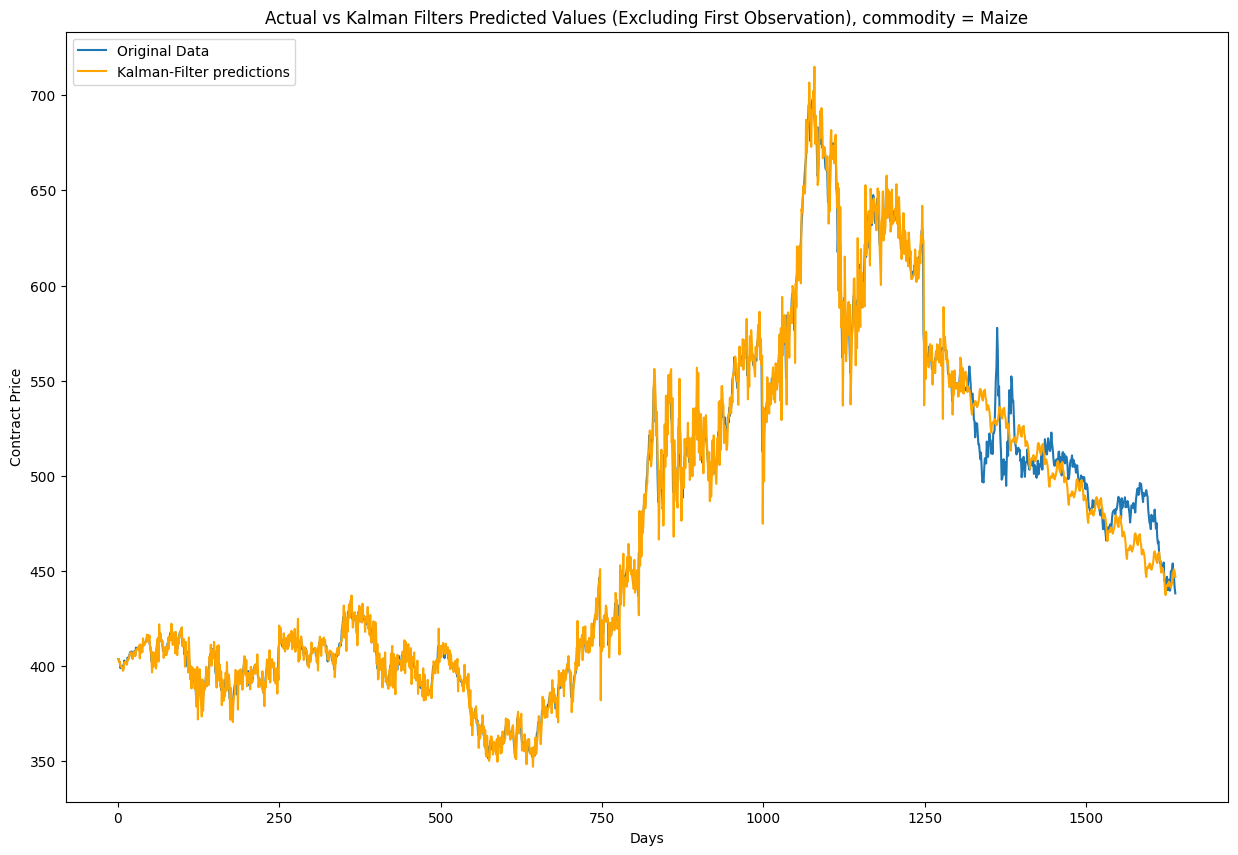

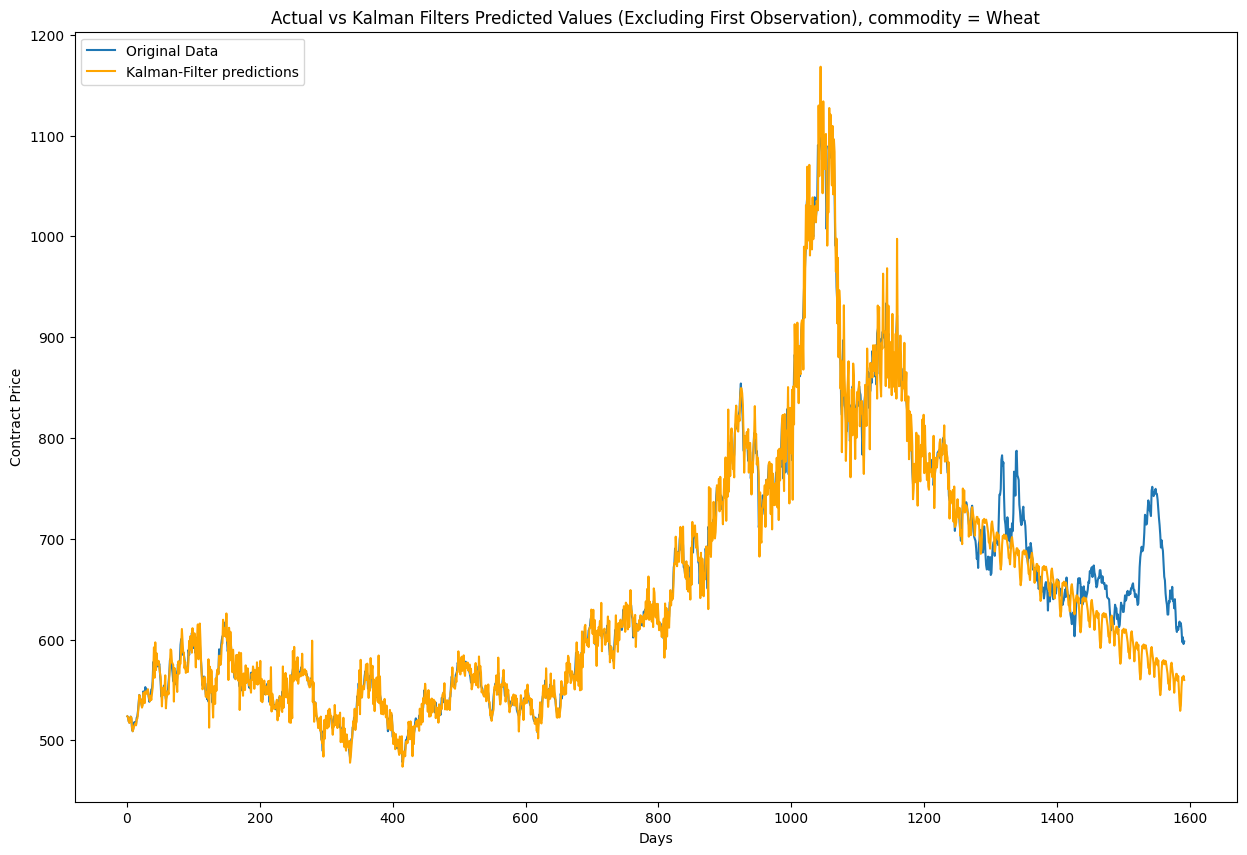

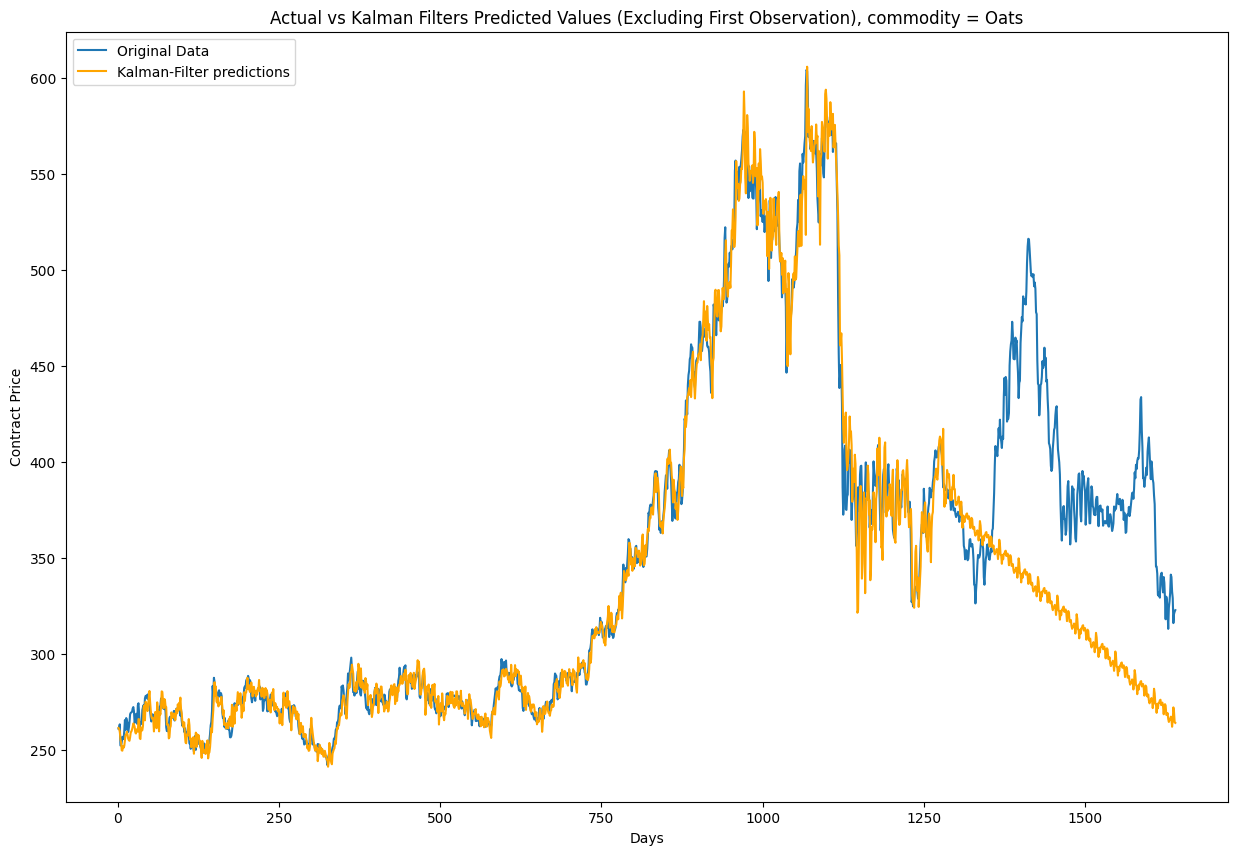

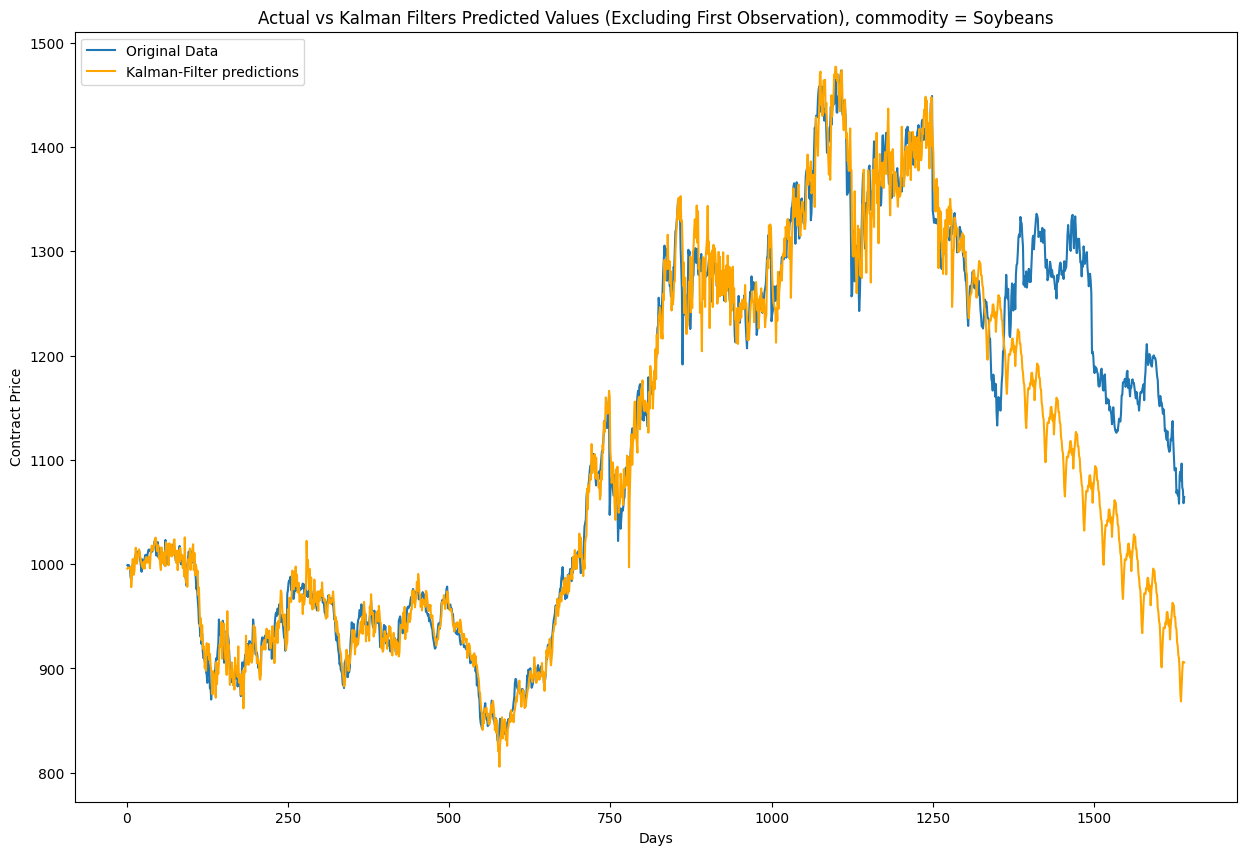

In [14]:
for j in range(len(commodities)):
    compute_rmse_with_plot(j,best_hyperparameters[j][0],best_hyperparameters[j][1])

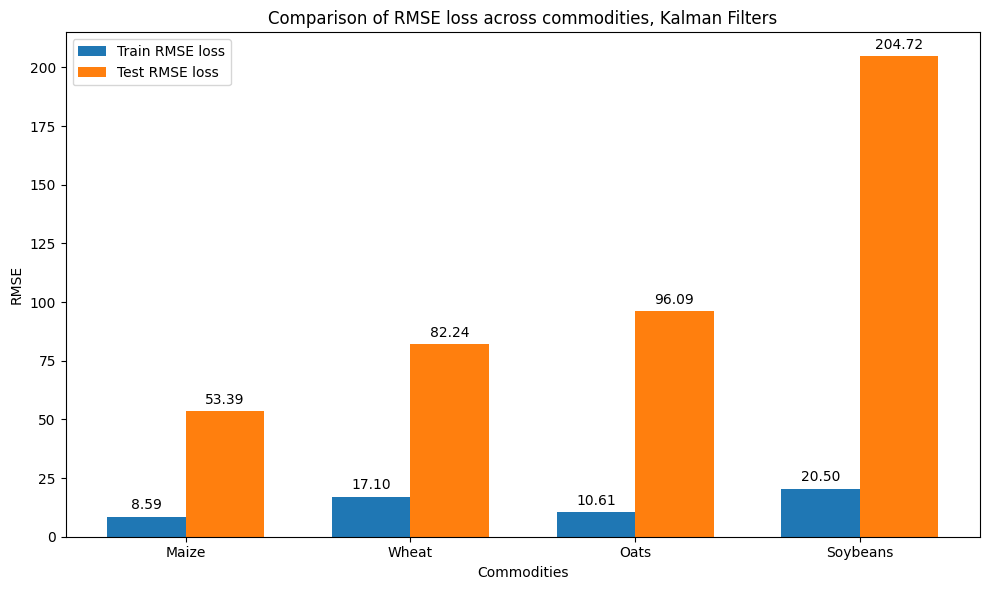

In [15]:
# RMSE values for each commodity: train and test losses
rmse_train = [x[0] for x in train_test_rmse]  # Example RMSE for train losses (4 commodities)
rmse_test = [x[1] for x in train_test_rmse]  # Example RMSE for test losses (4 commodities)

n_commodities = len(commodities)
ind = np.arange(n_commodities)  # the x locations for the commodities
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
train_bars = ax.bar(ind - width/2, rmse_train, width, label='Train RMSE loss')
test_bars = ax.bar(ind + width/2, rmse_test, width, label='Test RMSE loss')

ax.set_xlabel('Commodities')
ax.set_ylabel('RMSE')
ax.set_title('Comparison of RMSE loss across commodities, Kalman Filters')
ax.set_xticks(ind)
ax.set_xticklabels(commodities)
ax.legend()

# Function to add labels above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(train_bars)
add_labels(test_bars)
plt.tight_layout()
plt.show()


Compared to SARIMA models, the test results are clearly worse. This may be due to the fact that we did not account for yearly seasonality and only approximated monthly seasonality (as the models couldn't handle too many parameters). Another possible reason is the prediction methodology for test points, which is limited when predicting a large number of points. This is because we rely on the latest estimator, which is based on the training data, and as the series progresses, the predictions for the test points become less accurate. The fitting graphs show that the predictions deteriorated over time.